In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [845]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

# Sythetic data

## ToDos

1. General 
    1. rename "bumps" 
        1. as first as "segments" or "segs",
        2. then as "stays" with slopes and "slopes" as "travels"
    2. make it easier to have beginning and end points be different
        * start somewhere, but end somewhere else
        * _already_ easy to do this, but maybe with defaults
    3. make it automatic to find regions and add individual noise amplitudes to them
        1. use to validate the algo. via labeling and training
        2. add individual noise to stays to make them location- and stay-specific
            * make same noise for stays at same $x$?
    4. include a type selector for trajectory with top-hat or smooth bumps
2. Top-hat bumps
    1. include a slope limit which prevents a slope from taking more than half of a bump
    2. include pre- and post-bump slopes
        1. include option for these to be identical
    3. extend to multiple bumps
        1. include separate start- and end-points
            * default to same
            * create these first, then allow bumps to overwrite
                * Protocol:
                    1. specify start- and end-points
                    2. (over)write bumps
                    3. calculate slope regions
        2. generalize slopes between bumps $\to$ use average slope?
3. Smooth bumps
    1. make it more intuitive
    2. match the top-hat bump methodology
        * _Is it possible to use the top-hat bumps and then fit a tanh to the slope regions?_

    


In [5]:
import os, sys

In [6]:
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [7]:
import importlib
from stay_classification import synthetic_data

## Top-hat bumps

In [10]:
xxx = np.arange(0,100,0.1)

In [44]:
importlib.reload(synthetic_data);
from stay_classification.synthetic_data import get_1bump_tophat, get_bumps, get_noisy_bumps, get_noise

### Single bumps

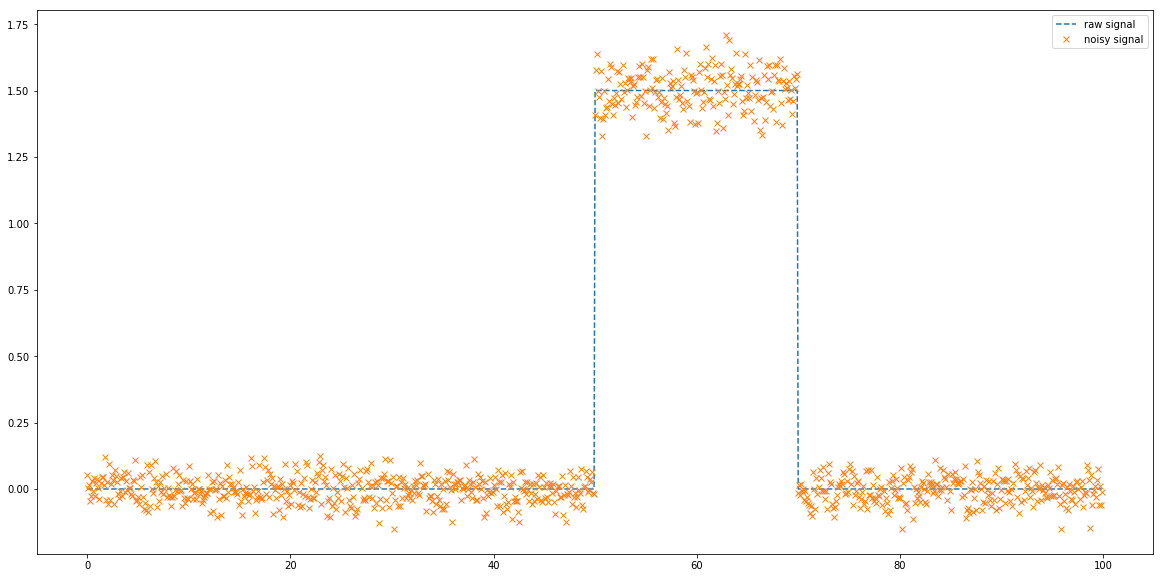

In [47]:
connect = 70
dc = {
        "bump0_amp":  1.5, "bump0_slope": 0.95, "bump0_slope_out": 0.95, "bump0_start": 50 , "bump0_end": connect
     }

yyy = get_bumps(xxx, **dc)

yyy0 = yyy.copy()
dc_noise = {"bump0_eta": 0.015}

dc.update(dc_noise)
yyyn = get_noise(yyy)

plt.figure(figsize=(20,10))
plt.plot(xxx, yyy, '--', label='raw signal')
plt.plot(xxx, yyyn, 'x', label='noisy signal')
plt.legend();

### Multiple bumps

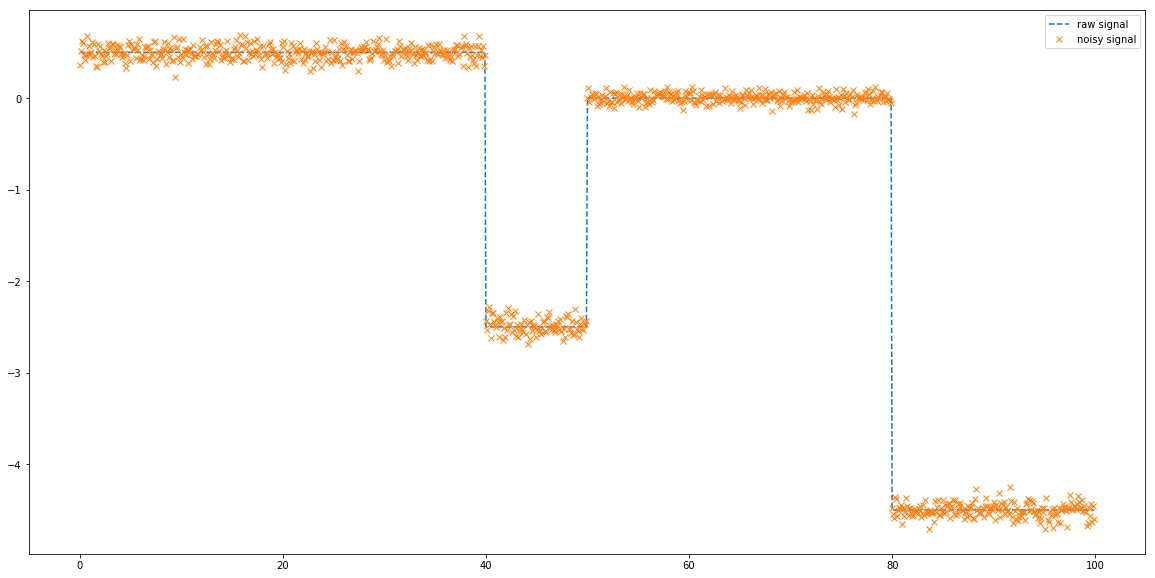

In [51]:
dc = {
        "bump0_amp":  0.5, "bump0_slope": 0.5, "bump0_start": -20 , "bump0_end": 40,
        "bump1_amp":  -2.5, "bump1_slope": 0.95, "bump1_start": 40 , "bump1_end": 50,
        "bump2_amp": -4.5, "bump2_slope": 0.75, "bump2_start": 80 , "bump2_end": 150
     }

yyy = 0*xxx

yyy = get_bumps(xxx, **dc)

yyy0 = yyy.copy()


dc_noise = {"bump0_eta": 0.015, "bump1_eta": 0.125}

#yyy = get_1bump(xxx, **dc)
dc.update(dc_noise)
yyyn = get_noise(yyy)

plt.figure(figsize=(20,10))
plt.plot(xxx, yyy, '--', label='raw signal')
plt.plot(xxx, yyyn, 'x', label='noisy signal')
plt.legend();

In [55]:
def get_bump_counts(dc):
    
    keys = []
    
    for k,v in dc.items():
        key = k.split('_')[0].replace('bump','')
        key = int(key)
        keys.append(key)
    
    keys = sorted(list(set(keys)))
    
    return keys

In [32]:
get_bump_counts(dc)

[0, 1, 2]

### Slope region (aka Travel) creation

In [56]:
get_x0 = lambda m,x,y,y0: x-((y-y0)/m)

In [ ]:
connect = 70
dc = {
        "bump0_amp":  1.5, "bump0_slope": 0.95, "bump0_slope_out": 0.95, "bump0_start": 50 , "bump0_end": connect
     }

yyy = get_bumps(xxx, **dc)
yyy0 = yyy.copy()

mask = np.where((xxx>=dc["bump0_start"]) & (xxx<dc['bump0_end']))

# Get the pre- & post-step indices
start_ind = mask[0][0]
end_ind = mask[0][-1]

# Get the midpoint values within the step
ymid_start = np.mean(yyy[start_ind-1:start_ind+1])
xmid_start = np.mean(xxx[start_ind-1:start_ind+1])

# Get the pre- & post-step amplitudes
y0_start_end = yyy[start_ind:start_ind+1][-1]
y0_start_start = yyy[start_ind-1:start_ind][0]

# Get the pre- & post-step amplitudes
y0_end_end = yyy[end_ind:end_ind+2][-1]
y0_end_start = yyy[end_ind-1:end_ind][-1]

# Get the midpoint values within the step
ymid_end = np.mean(yyy[end_ind:end_ind+2])
xmid_end = np.mean(xxx[end_ind-1:end_ind+1])

slope = dc['bump0_slope']

# Get the x-locations for the start and end of the sloped region
x0_start_end = get_x0(slope, xmid_start, ymid_start, y0_start_end)
x0_start_start = get_x0(slope, xmid_start, ymid_start, y0_start_start)
slope_mask = np.where((xxx>=x0_start_start) & (xxx<x0_start_end))

# Compute the sloped region
yyy[slope_mask] = slope*(xxx[slope_mask]-x0_start_start) + y0_start_start

# Get the x-locations for the start and end of the sloped region
return_slope = -slope
x0_end_start = get_x0(return_slope, xmid_end, ymid_end, y0_end_start)
x0_end_end   = get_x0(return_slope, xmid_end, ymid_end, y0_end_end)
slope_mask = np.where((xxx>=x0_end_start) & (xxx<x0_end_end))

# Compute the sloped region
yyy[slope_mask] = return_slope*(xxx[slope_mask]-x0_end_start) + y0_end_start

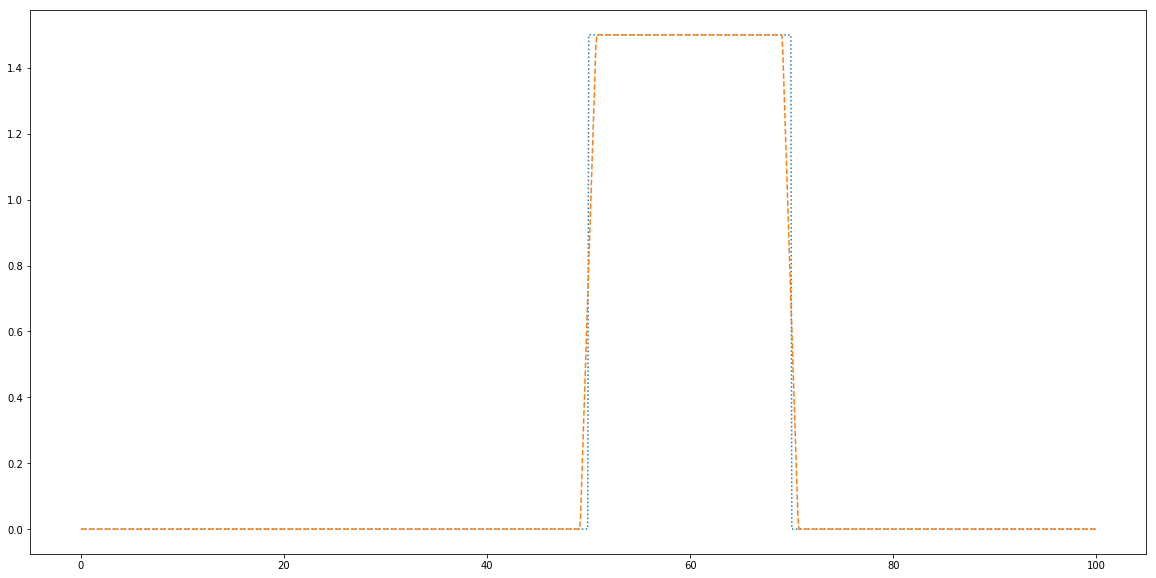

In [59]:
plt.figure(figsize=(20,10))
plt.plot(xxx, yyy0, ':', label=r'$y_0(x)$')

# plot
plt.plot(xxx, yyy, '--', label=f'slope = {slope}')

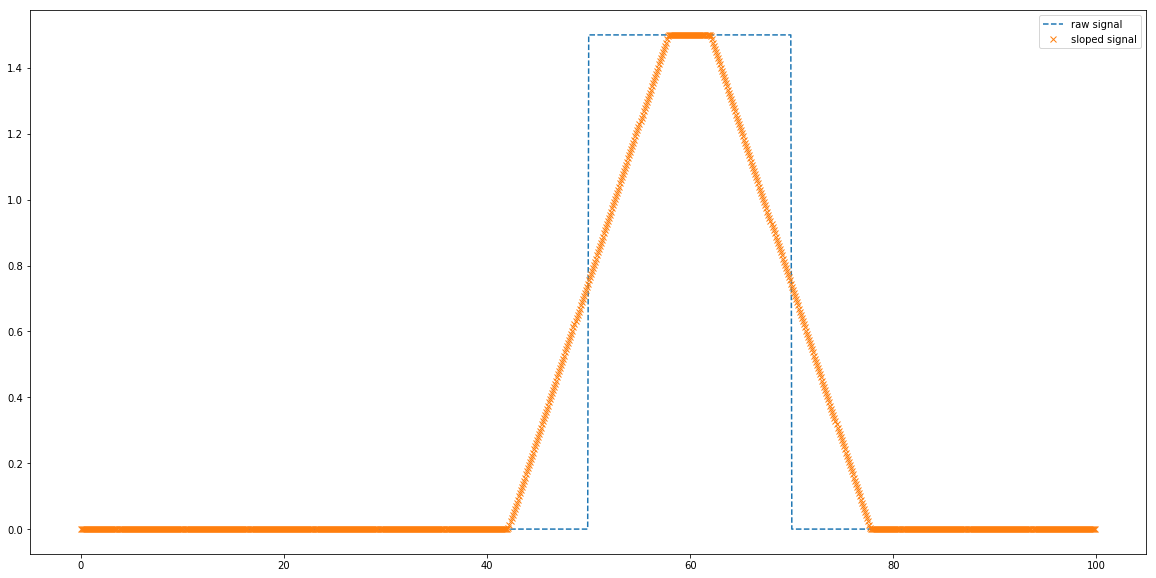

In [63]:
importlib.reload(synthetic_data);
from stay_classification.synthetic_data import get_sloped_bumps

connect = 70
dc = {
        "bump0_amp":  1.5, "bump0_slope": 0.095, "bump0_slope_out": 0.95, "bump0_start": 50 , "bump0_end": connect
     }

yyy = get_bumps(xxx, **dc)

yyys = get_sloped_bumps(xxx,yyy,**dc)

yyy0 = yyy.copy()
dc_noise = {"bump0_eta": 0.015}

dc.update(dc_noise)
yyyn = get_noise(yyy)

plt.figure(figsize=(20,10))
plt.plot(xxx, yyy, '--', label='raw signal')
plt.plot(xxx, yyys, 'x', label='sloped signal')

plt.legend();

3
0 -20 40 0 399
1 40 50 400 499
2 80 150 800 999


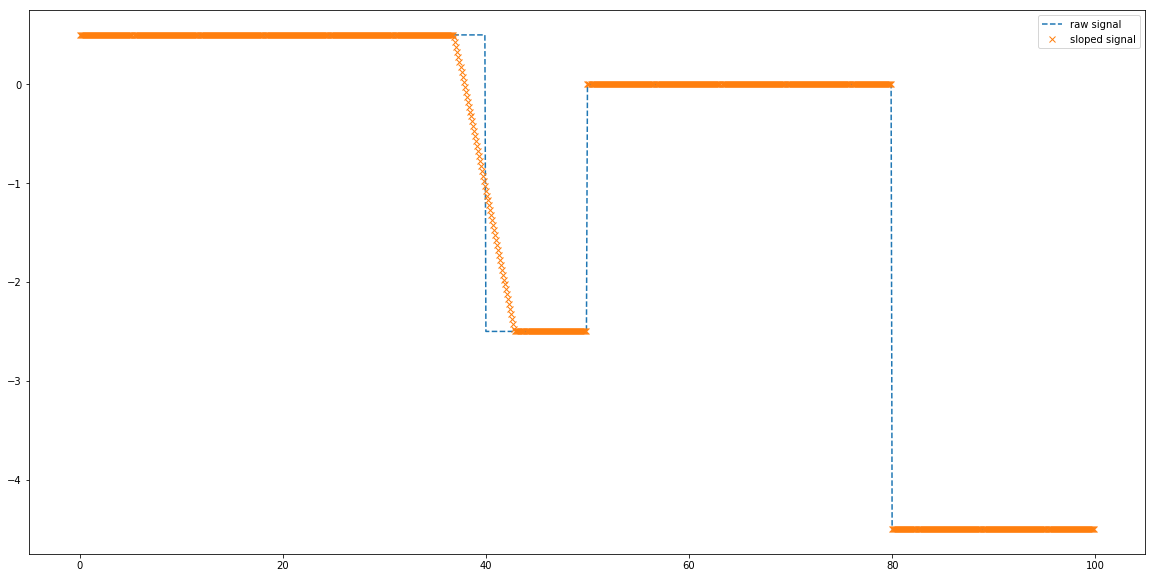

In [84]:
importlib.reload(synthetic_data);
from stay_classification.synthetic_data import get_sloped_bumps

dc = {
        "bump0_amp":  0.5, "bump0_slope": 0.5, "bump0_start": -20 , "bump0_end": 40,
        "bump1_amp":  -2.5, "bump1_slope": 0.095, "bump1_start": 40 , "bump1_end": 50,
        "bump2_amp": -4.5, "bump2_slope": 0.075, "bump2_start": 80 , "bump2_end": 150
     }

yyy = get_bumps(xxx, **dc)

yyys = get_sloped_bumps(xxx,yyy,**dc)

yyy0 = yyy.copy()


dc_noise = {"bump0_eta": 0.015, "bump1_eta": 0.125}

#yyy = get_1bump(xxx, **dc)
dc.update(dc_noise)
yyyn = get_noise(yyy)

plt.figure(figsize=(20,10))
plt.plot(xxx, yyy, '--', label='raw signal')
plt.plot(xxx, yyys, 'x', label='sloped signal')
plt.legend();

In [234]:
# get a dict to map the regions to the bumps
get_newk = lambda k: k.replace('bump','').replace('_amp','')
get_amps = {v:get_newk(k) for k,v in dc.items() if 'amp' in k}

print(get_amps)

{0.5: '0', -2.5: '1', -4.5: '2'}


In [235]:
# Get the range of the region
def get_range(yy,value):
    test_list = []
    for ind, nr in enumerate(yy):
        if nr != value:
            break
        else:
            test_list.append(ind)
    # Note: this is the _next_ point, outside of the region
    return ind

In [238]:
# Find the change points of the regions 
# Note: these may be different from the specified start- and end-points
value = yyy[0]
m = 0
change_points = [m]
while m < yyy.size-1:
    ind = get_range(yyy[m:],value)+m
    change_points.append(ind)
    m = ind
    value = yyy[m]
change_points = change_points[:-1]    
print(change_points)

[0, 400, 500, 800]


In [243]:
for ind,n in enumerate(change_points):
    m = max(n-1,0)
    #print(yyy[n])
    val = yyy[n]
    if val in get_amps.keys():
        bumpind = get_amps[yyy[n]]
        print(f'Region {ind} has bump{bumpind}_amp = {val}')
        
        if ind != 0:
            print('\tuse max slope')
        else:
            print('\tuse dict slope')
        
    else:         
        print(f'Region {ind} is new with {val}')

Region 0 has bump0_amp = 0.5
	use dict slope
Region 1 has bump1_amp = -2.5
	use max slope
Region 2 is new with 0.0
Region 3 has bump2_amp = -4.5
	use max slope


### New inputs

In [ ]:
def get_segments(seg_list):
    
    keys = []
    
    for k,v in dc.items():
        
        keys.append((k.split('_')[0].replace('bump','')))
    
    keys = list(set(keys))
    
    return keys

## Get a new method for allocating stays and travels

**Notes**
* specify the beginning and ends of stays, along with location (formally, the _amp_)
* specify the slope of the travel
    * the location of the travel will be sorted to maximize the slope, cutting the adjacent stays as needed
    * if stays don't attach, _ie_ are separated by multiple points, the travel connects the endpoints indept. of slope
* will have an error checking in place to assure that there are always [stay, trav, ..., trav, stay] 

**ToDos**

1. set up single list of stays: $t_0, t_1, x$
    * a default $m=0$ for the slope will be included
2. generate a complimentary list of travels: $t_0, t_1, x, m$
    * $m$ is the slope
    * **!!!** get the data without generating the output array
3. interleave the two lists
4. Generate the whole journey
    * should be a single generic function

```
get_stay = lambda start,stop, loc:  {"type": "stay", "loc":  loc, "start": start, "end":  stop}
get_trav = lambda slope:  {"type": "trav", "slope":  slope}
```

```
chain = [

        get_stay(0, 30, 0.5),

        get_trav(0.9),  

        get_stay( 40, 50,-2.5), 

        get_trav(0.5), 

        get_stay( 80,150,-4.5)

    ]

def get_segments(x, seg_list):
    
    '''
    TODO: check if the dict is complete, also with some defaults
    if (len(kwargs)%4 != 0) & :
        assert len(kwargs)%4 == 0, "Number of kwargs is wrong!"
    '''

    fff = np.zeros(x.size)
    
    for n,seg in enumerate(seg_list):

        
        if seg['type'] == 'stay':
            amp   = seg[f'amp']     
            start = seg[f'start']
            end   = seg[f'end']    
        else: 
            continue
            slope = seg[f'slope']
            
        '''
        slope_out_key = f'bump{n}_slope_out'
        if slope_out_key in kwargs.keys():
            slope_out = kwargs[slope_out_key]
        else:
            slope_out = -kwargs[f'bump{n}_slope']
        '''
        
        start_ind = np.where((x>=start))[0][0]

        end_ind = np.where((x<end))[0][0]

        mask = np.where((x>=start) & (x<end))
        
        fff[mask] = amp        
        
    return fff

chian = range(5)
#seg_list[:,-2],seg_list[2:]
def get_slopes(x, y, seg_list):
    
    fff = y.copy()
    
    get_slope = lambda x1,y1,x2,y2: (y1-y2)/(x1-x2)
    for seg1, seg2 in list(zip(seg_list[:-2:2],seg_list[2::2])):

        loc1   = seg1[f'loc']     
        end1   = seg1[f'end'] 
        end1_ind = np.where((x<end1))[0][-1]

        loc2   = seg2[f'loc']     
        start2 = seg2[f'start']
        start2_ind = np.where((x>=start2))[0][0]
        
        m = get_slope(end1,loc1,start2,loc2)
        print(m,end1_ind,start2_ind)
        fff[end1_ind+1:start2_ind] = m*(x[end1_ind+1:start2_ind]-end1) + loc1
            
    return fff

```

In [604]:
import warnings

### the stays

In [796]:
'''chain = [
        get_stay(  0, 0,  0.5),
        #get_stay( 10, 20,-1.5), 
        get_stay( 30, 40, 1.5),
        #get_stay( 55, 60, 0.5),
        get_stay( 70, 80,-2.0), 
        get_stay( 90,100,-4.5)
    ]
'''
stays = [
        get_stay(  0, 15, -1.10),
        get_stay( 25, 28,-1.15), 
        get_stay( 30, 35,-1.60), 
        get_stay( 38, 40,-1.90),
        get_stay( 45, 70,-2), 
        get_stay( 100,100,0)
    ]

for link in stays:
    print(link)

{'type': 'stay', 'loc': -1.1, 'start': 0, 'end': 15, 'slope': 0}
{'type': 'stay', 'loc': -1.15, 'start': 25, 'end': 28, 'slope': 0}
{'type': 'stay', 'loc': -1.6, 'start': 30, 'end': 35, 'slope': 0}
{'type': 'stay', 'loc': -1.9, 'start': 38, 'end': 40, 'slope': 0}
{'type': 'stay', 'loc': -2, 'start': 45, 'end': 70, 'slope': 0}
{'type': 'stay', 'loc': 0, 'start': 100, 'end': 100, 'slope': 0}


### from stays, get travels

In [825]:
segments = linterleave(stays,get_slopes(xxx, stays))
for seg in segments:
    print(seg)

{'type': 'stay', 'loc': -1.1, 'start': 0, 'end': 15, 'slope': 0}
{'type': 'trav', 'loc': -1.1, 'start': 15.0, 'end': 25.0, 'slope': -0.004999999999999982}
{'type': 'stay', 'loc': -1.15, 'start': 25, 'end': 28, 'slope': 0}
{'type': 'trav', 'loc': -1.15, 'start': 28.0, 'end': 30.0, 'slope': -0.2250000000000001}
{'type': 'stay', 'loc': -1.6, 'start': 30, 'end': 35, 'slope': 0}
{'type': 'trav', 'loc': -1.6, 'start': 35.0, 'end': 38.0, 'slope': -0.09999999999999994}
{'type': 'stay', 'loc': -1.9, 'start': 38, 'end': 40, 'slope': 0}
{'type': 'trav', 'loc': -1.9, 'start': 40.0, 'end': 45.0, 'slope': -0.020000000000000018}
{'type': 'stay', 'loc': -2, 'start': 45, 'end': 70, 'slope': 0}
{'type': 'trav', 'loc': -2, 'start': 70.0, 'end': 99.9, 'slope': 0.06666666666666667}
{'type': 'stay', 'loc': 0, 'start': 100, 'end': 100, 'slope': 0}


/home/sandm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: the distance between the consecutive locations is within the threshold 0.5


In [826]:
def get_slopes_old(x, y, seg_list, threshold=0.5):
    
    fff = y.copy()
    
    get_slope = lambda x1,y1,x2,y2: (y1-y2)/(x1-x2)
    
    for seg1, seg2 in list(zip(seg_list[:-1],seg_list[1:])):

        loc1   = seg1[f'loc']
        start1   = seg1[f'start'] 
        end1   = seg1[f'end'] 
        
        if start1 < end1:
            end1_ind = np.where((x<end1))[0][-1]
        else: 
            end1_ind = np.where((x==end1))[0][0]
            
        loc2   = seg2[f'loc']
        start2 = seg2[f'start']
        start2_ind = np.where((x>=start2))[0][0]
        
        if np.abs(loc1-loc2) < threshold:
            warnings.warn(f"the distance between the consecutive locations is within the threshold {threshold}")
        
        m = get_slope(end1,loc1,start2,loc2)
        
        fff[end1_ind+1:start2_ind] = m*(x[end1_ind+1:start2_ind]-end1) + loc1
    
    return fff

In [797]:
get_stay = lambda start,stop,loc,slope=0: {"type": "stay", "loc":  loc, "start": start, "end":  stop, "slope":  slope}
get_trav = lambda start,stop,loc,slope:   {"type": "trav", "loc":  loc, "start": start, "end":  stop, "slope":  slope}

def get_slopes(x, seg_list, threshold=0.5):
    
    travels = []
    
    get_slope = lambda x1,y1,x2,y2: (y1-y2)/(x1-x2)    
    
    for seg1, seg2 in list(zip(seg_list[:-1],seg_list[1:])):

        # Get the quantities
        loc1   = seg1[f'loc']
        start1   = seg1[f'start'] 
        end1   = seg1[f'end'] 
        
        loc2   = seg2[f'loc']
        start2 = seg2[f'start']
        end2   = seg2[f'end'] 
        
        # Adjust the endpoints as needed
        start1 = max(start1,x[0])
        start2 = max(start2,x[0])
        end1 = min(end1,x[-1])
        end2 = min(end2,x[-1])
        
        
        # Get the indices; check if overlapping
        #### TODO: put in some asserts (do this earlier!)
        if start1 < end1:
            end1_ind = np.where((x <end1))[0][-1]
        else: 
            end1_ind = np.where((x==end1))[0][ 0]        
        
        # Get the indices
        if start2 < end2:
            start2_ind = np.where((x>=start2))[0][0]
        else: 
            start2_ind = np.where((x==end2))[0][ 0]
        
        if np.abs(loc1-loc2) < threshold:
            warnings.warn(f"the distance between the consecutive locations is within the threshold {threshold}")
        
        slope = get_slope(end1,loc1,start2,loc2)
        
        #fff[end1_ind+1:start2_ind] = m*(x[end1_ind+1:start2_ind]-end1) + loc1
    
        travels.append(get_trav(x[end1_ind+1], x[start2_ind], loc1, slope))
        
    return travels #fff

def get_stays(x, seg_list):   
    '''
    TODO: check if the dict is complete, also with some defaults
    if (len(kwargs)%4 != 0) & :
        assert len(kwargs)%4 == 0, "Number of kwargs is wrong!"
    '''

    fff = np.zeros(x.size)
    
    for seg in seg_list:

        
        loc   = seg[f'loc']     
        start = seg[f'start']
        end   = seg[f'end']    
        
        if start < end:
            start_ind = np.where((x>=start))[0][0]
            end_ind = np.where((x<end))[0][0]
        
            mask = np.where((x>=start) & (x<end))
        else:
            mask = np.where((x==start))
        
        fff[mask] = loc        
        
    return fff

def get_travels(x, y, seg_list, threshold=0.5):
    
    fff = y.copy()
    
    for seg in seg_list:

        
        slope = seg[f'slope']     
        start = seg[f'start']
        loc = seg[f'loc']
        end   = seg[f'end']    
        
        print(seg)
        
        if start < end:
            start_ind = np.where((x>=start))[0][0]
            end_ind = np.where((x<end))[0][0]
        
            mask = np.where((x>=start) & (x<end))
        else:
            mask = np.where((x==start))
            
        
        #fff[start+1:end] = m*(x[start+1:end]-x[start]) + loc
        fff[mask] = slope*(x[mask]-end) + loc
    
    return fff

def get_journey(x, seg_list, threshold=0.5):
    
    fff = np.zeros(x.size)
    
    for seg in seg_list:

        # Get the segment details
        slope = seg[f'slope']     
        start = seg[f'start']
        loc   = seg[f'loc']
        end   = seg[f'end']    
        
        # Find the associated indices
        if start < end:    
            start_ind = np.where((x>=start))[0][0]
            end_ind = np.where((x<end))[0][0]
            mask = np.where((x>=start) & (x<end))        
        else:
            # For single point stays (in beginning/end)
            mask = np.where((x==start))
        
        # Create the line semgnet
        if slope == 0:
            fff[mask] = loc
        else:
            fff[mask] = slope*(x[mask]-start) + loc
    
    return fff

def get_segments(x, stays, threshold=0.5):
    
    segments = linterleave(stays,get_slopes(x, stays))
    
    return segments


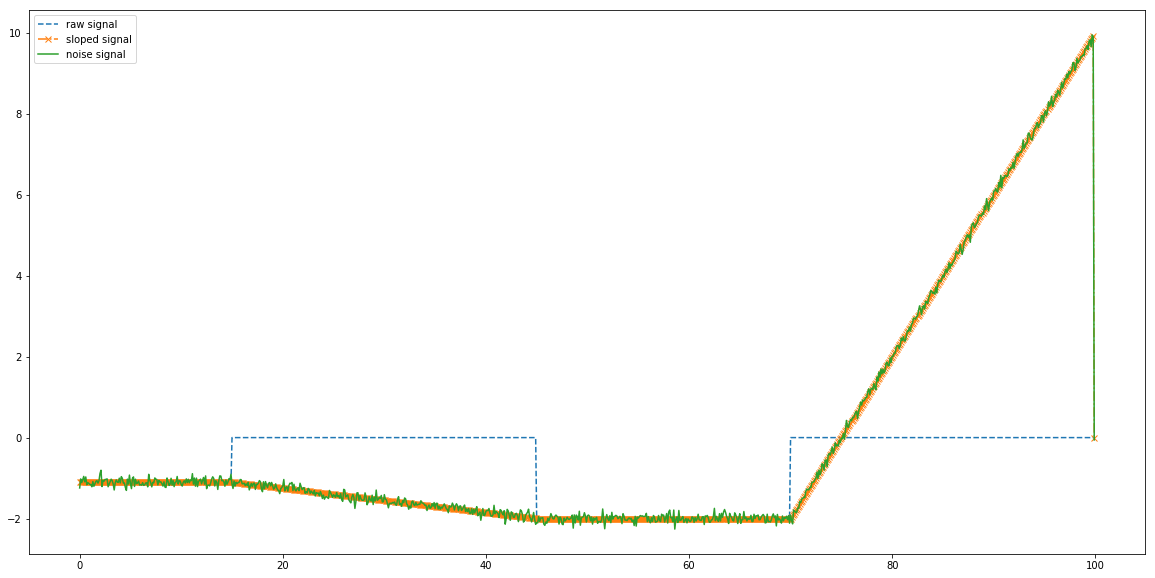

In [914]:
stays = [
        get_stay(  0, 15, -1.10),
        get_stay( 45, 70,-2), 
        get_stay( 100,100,10)
    ]

yyy = get_stays(xxx, stays)
#yyys = get_slopes(xxx,yyy, chain)

yyys = get_journey(xxx,get_segments(xxx, stays, threshold=0.5))
yyyn = get_noise(yyys)

plt.figure(figsize=(20,10))
plt.plot(xxx, yyy, '--', label='raw signal')
plt.plot(xxx, yyys, 'x-.', label='sloped signal')
plt.plot(xxx, yyyn, '-', label='noise signal')
plt.legend();

In [852]:
get_stay_info =  lambda stay: (stay['loc'], stay['start'], stay['end'], stay['slope'])

In [856]:
a,b,c,d = get_stay_info(stays[0])
print(a)

-1.1


In [857]:
from stay_classification import synthetic_data

In [859]:
from stay_classification.synthetic_data import get_travel_paths, get_stay_paths, get_journey_path

In [931]:
get_stay = lambda start,stop,loc,slope=0: {"type": "stay", "loc":  loc, "start": start, "end":  stop, "slope":  slope}

get_trav = lambda start,stop,loc,slope:   {"type": "trav", "loc":  loc, "start": start, "end":  stop, "slope":  slope}

get_seg  = lambda start,stop,loc,slope=0: get_stay(start,stop,loc,slope) if slope == 0 else get_trav(start,stop,loc,slope)


In [932]:
get_seg(  0,  20,  2)

{'type': 'stay', 'loc': 2, 'start': 0, 'end': 20, 'slope': 0}

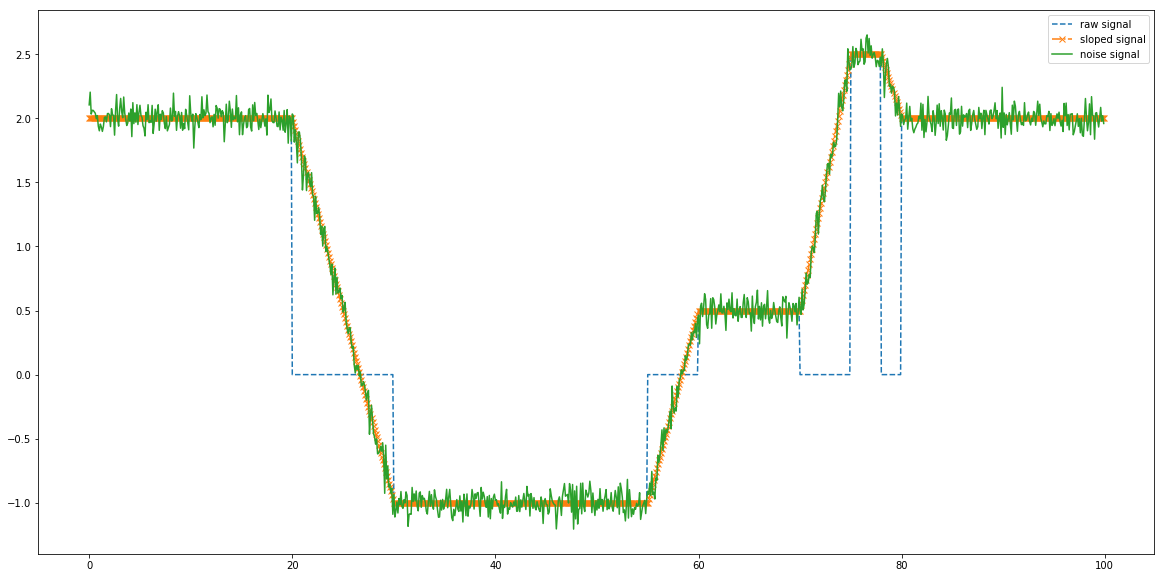

In [939]:
stays = [
        get_stay(  0,  20,  2),
        get_stay( 30,  55, -1),
        get_stay( 60,  70,  0.5),
        get_stay( 75,  78,  2.5),
        get_stay( 80, 100,  2)
    ]

yyy = get_stay_paths(xxx, stays)
#yyys = get_slopes(xxx,yyy, chain)

yyys = get_journey_path(xxx,get_segments(xxx, stays, threshold=0.5))
yyyn = get_noise(yyys)

plt.figure(figsize=(20,10))
plt.plot(xxx, yyy, '--', label='raw signal')
plt.plot(xxx, yyys, 'x-.', label='sloped signal')
plt.plot(xxx, yyyn, '-', label='noise signal')
plt.legend();

In [920]:
yyys[0:10],yyys[-10:-1]

(array([2.   , 2.   , 1.969, 1.938, 1.907, 1.876, 1.845, 1.814, 1.783,
        1.752]), array([0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98]))

In [873]:
x_buff = np.mean(np.abs(xxx[:-1]-xxx[1:]))
np.where((xxx>=100.0-x_buff) & (xxx<100.0+x_buff))

(array([999]),)

In [839]:
if True:
    raise AssertionError('this didnt work')

AssertionError: this didnt work

In [844]:
assert 1 > 2, 'These are false'

AssertionError: These are false

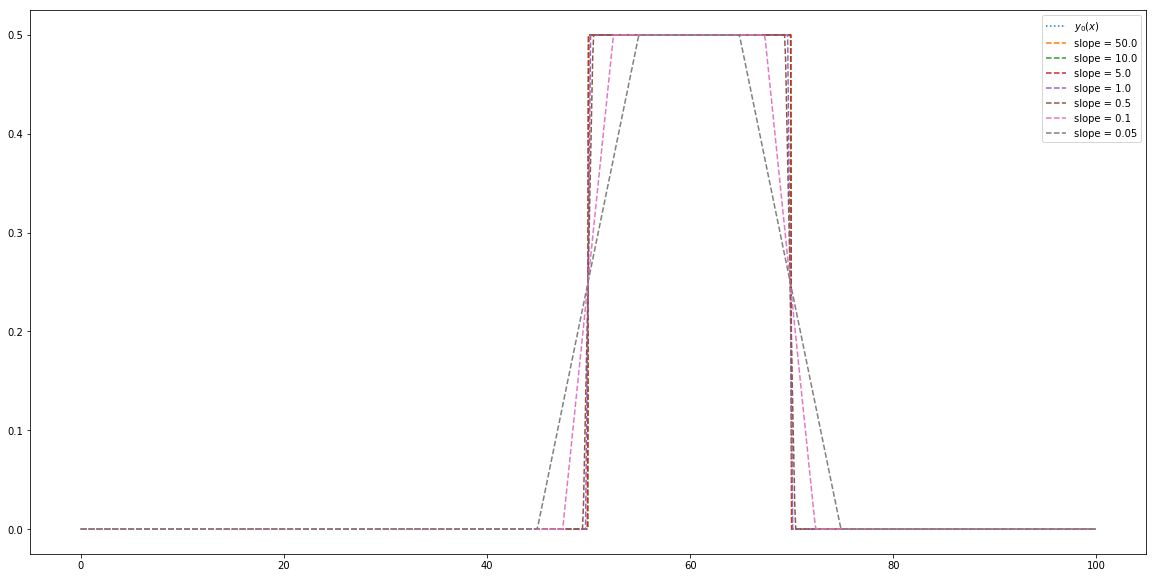

In [210]:
# Make a copy for each plot
yyy = yyy0.copy()

# Get the pre- & post-step indices
bump1_start_ind = bump1_mask[0][0]
bump1_end_ind = bump1_mask[0][-1]

# Get the midpoint values within the step
ymid_start = np.mean(yyy[bump1_start_ind-1:bump1_start_ind+1])
xmid_start = np.mean(xxx[bump1_start_ind-1:bump1_start_ind+1])

# Get the pre- & post-step amplitudes
y0_end_end = yyy[bump1_end_ind:bump1_end_ind+2][-1]
y0_end_start = yyy[bump1_end_ind-1:bump1_end_ind][-1]

# Get the midpoint values within the step
ymid_end = np.mean(yyy[bump1_end_ind:bump1_end_ind+2])
xmid_end = np.mean(xxx[bump1_end_ind:bump1_end_ind+2])


plt.figure(figsize=(20,10))
plt.plot(xxx, yyy0, ':', label=r'$y_0(x)$')

for bump1_slope in np.array([50, 10, 5, 1, 0.5, 0.1, 0.05]):
    
    # Get the x-locations for the start and end of the sloped region
    x0_start_end = get_x0(bump1_slope, xmid_start, ymid_start, y0_start_end)
    x0_start_start = get_x0(bump1_slope, xmid_start, ymid_start, y0_start_start)
    bump1_slope_mask = np.where((xxx>=x0_start_start) & (xxx<x0_start_end))

    # Compute the sloped region
    yyy[bump1_slope_mask] = bump1_slope*(xxx[bump1_slope_mask]-x0_start_start) + y0_start_start

    # Get the x-locations for the start and end of the sloped region
    return_slope = -bump1_slope
    x0_end_start = get_x0(return_slope, xmid_end, ymid_end, y0_end_start)
    x0_end_end   = get_x0(return_slope, xmid_end, ymid_end, y0_end_end)
    bump1_slope_mask = np.where((xxx>=x0_end_start) & (xxx<x0_end_end))

    # Compute the sloped region
    yyy[bump1_slope_mask] = return_slope*(xxx[bump1_slope_mask]-x0_end_start) + y0_end_start
    
    # plot
    plt.plot(xxx, yyy, '--', label=f'slope = {bump1_slope}')

plt.legend();

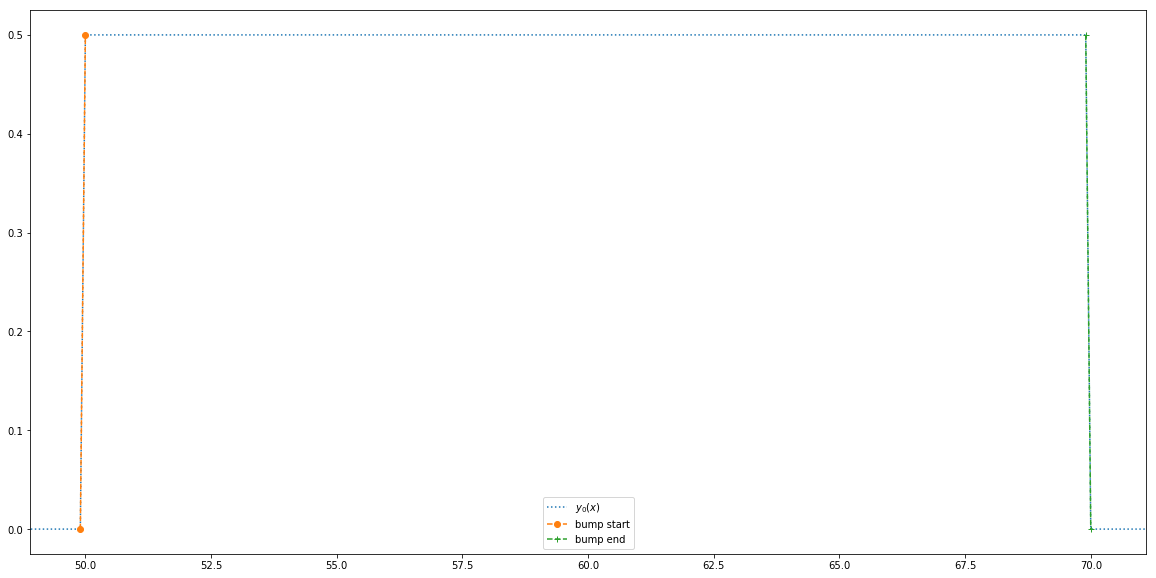

In [220]:
# Make a copy for each plot
yyy = yyy0.copy()

# Get the midpoint values within the step
plt.figure(figsize=(20,10))

plt.plot(xxx, yyy0, ':', label=r'$y_0(x)$')

plt.plot(xxx[bump1_start_ind-1:bump1_start_ind+1],yyy[bump1_start_ind-1:bump1_start_ind+1],'o--', label=f'bump start')
plt.plot(xxx[bump1_end_ind:bump1_end_ind+2],yyy[bump1_end_ind:bump1_end_ind+2],'+--', label=f'bump end')
plt.xlim(xxx[bump1_start_ind-11],xxx[bump1_end_ind+12])
plt.legend();

## Smooth bumps

In [175]:
yyy[bump1_slope_mask]

array([0.5025, 0.5075, 0.5125, 0.5175, 0.5225, 0.5275, 0.5325, 0.5375,
       0.5425, 0.5475, 0.5525, 0.5575, 0.5625, 0.5675, 0.5725, 0.5775,
       0.5825, 0.5875, 0.5925, 0.5975, 0.6025, 0.6075, 0.6125, 0.6175,
       0.6225, 0.6275, 0.6325, 0.6375, 0.6425, 0.6475, 0.6525, 0.6575,
       0.6625, 0.6675, 0.6725, 0.6775, 0.6825, 0.6875, 0.6925, 0.6975,
       0.7025, 0.7075, 0.7125, 0.7175, 0.7225, 0.7275, 0.7325, 0.7375,
       0.7425, 0.7475, 0.7525, 0.7575, 0.7625, 0.7675, 0.7725, 0.7775,
       0.7825, 0.7875, 0.7925, 0.7975, 0.8025, 0.8075, 0.8125, 0.8175,
       0.8225, 0.8275, 0.8325, 0.8375, 0.8425, 0.8475, 0.8525, 0.8575,
       0.8625, 0.8675, 0.8725, 0.8775, 0.8825, 0.8875, 0.8925, 0.8975,
       0.9025, 0.9075, 0.9125, 0.9175, 0.9225, 0.9275, 0.9325, 0.9375,
       0.9425, 0.9475, 0.9525, 0.9575, 0.9625, 0.9675, 0.9725, 0.9775,
       0.9825, 0.9875, 0.9925, 0.9975])

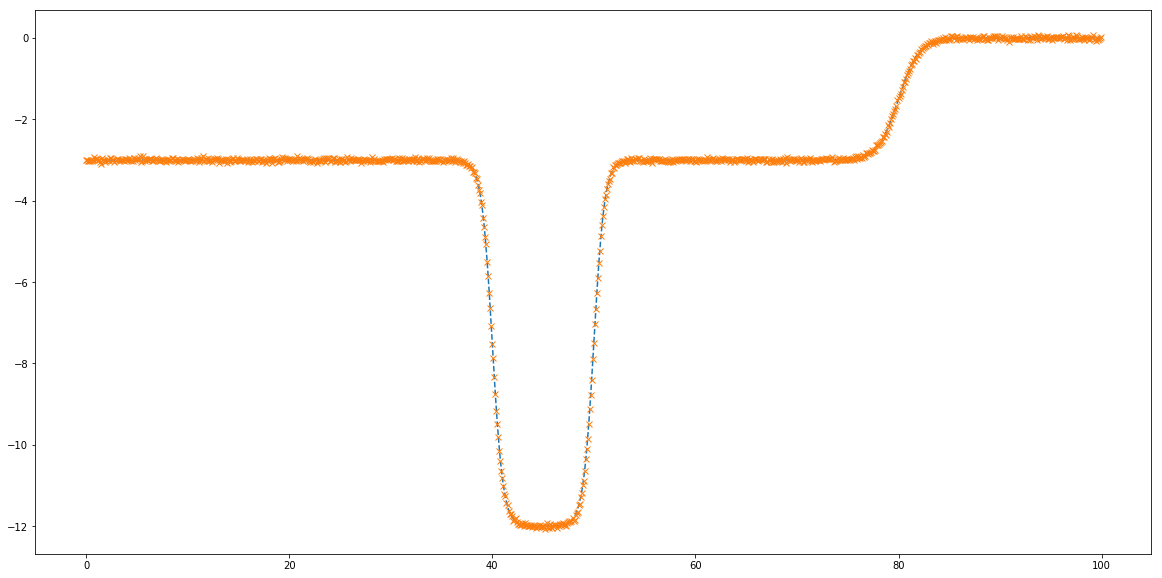

In [7]:
dc = {
        "bump1_amp":  -1.5, "bump1_slope": 0.5, "bump1_start": -20 , "bump1_end": 80,
        "bump2_amp": -4.5, "bump2_slope": 0.95, "bump2_start": 40 , "bump2_end": 50
     }

dc_noise = {"bump1_eta": 0.015, "bump2_eta": 0.025}

yyy = get_bumps(xxx, **dc)
dc.update(dc_noise)
yyyn = get_noisy_bumps(xxx, **dc)

plt.figure(figsize=(20,10))
plt.plot(xxx, yyy, '--')
plt.plot(xxx, yyyn, 'x')

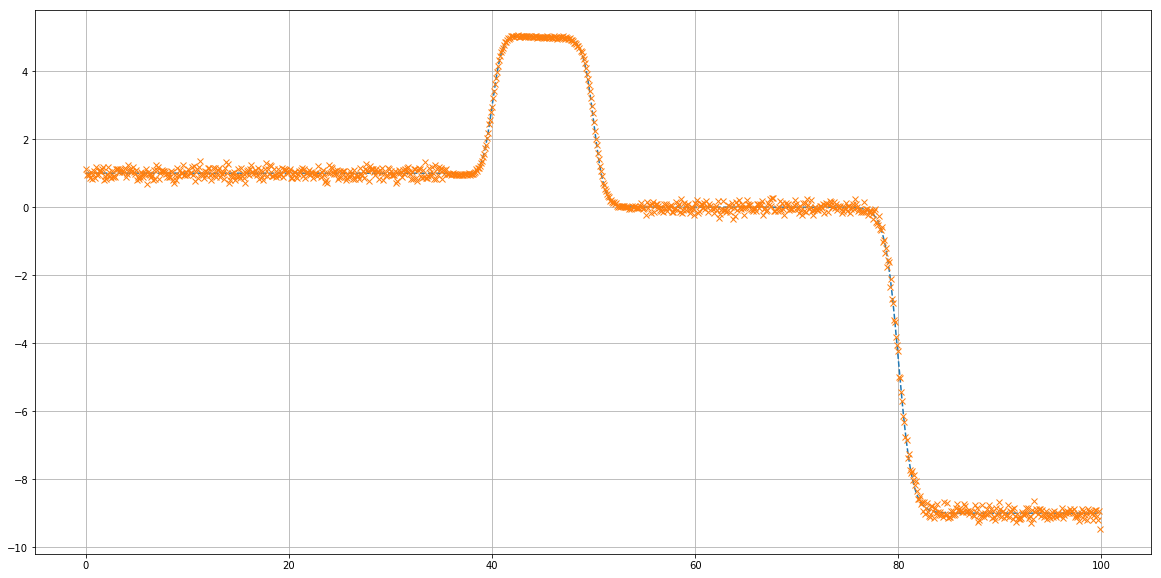

In [8]:
dc = {
        "bump1_amp":  0.5, "bump1_slope": 0.5, "bump1_start": -20 , "bump1_end": 40,
        "bump2_amp":  2.5, "bump2_slope": 0.95, "bump2_start": 40 , "bump2_end": 50,
        "bump3_amp": -4.5, "bump3_slope": 0.75, "bump3_start": 80 , "bump3_end": 150
     }

dc_noise = {"bump1_eta": 0.015, "bump2_eta": 0.125, "bump3_eta": 0.015}

yyy = get_bumps(xxx, **dc)
dc.update(dc_noise)
yyyn = get_noisy_bumps(xxx, **dc)

plt.figure(figsize=(20,10))
plt.plot(xxx, yyy, '--')
plt.plot(xxx, yyyn, 'x')
plt.grid()

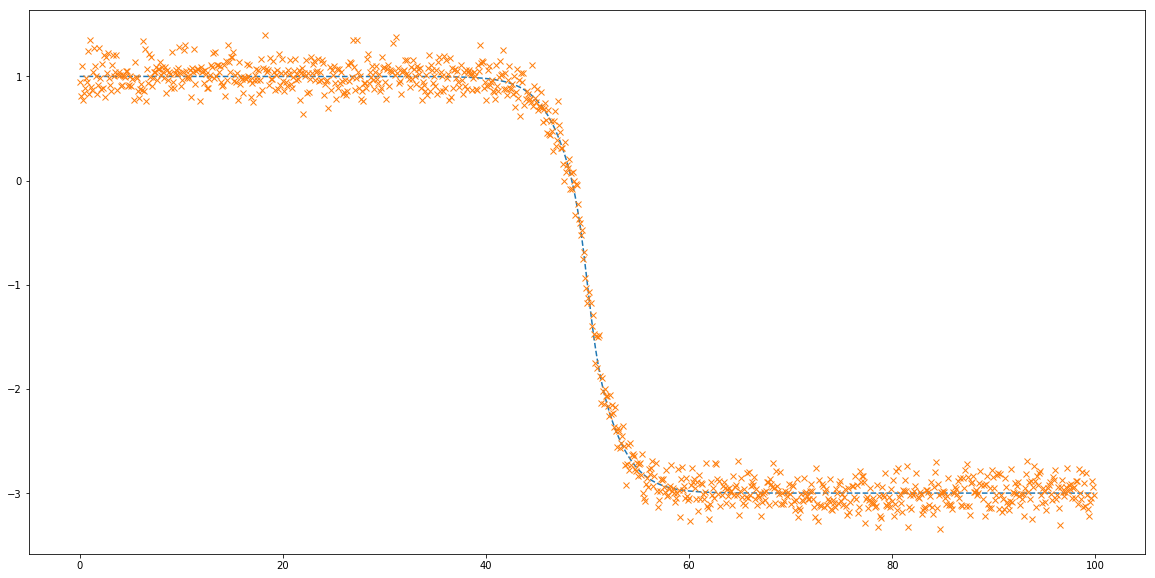

In [9]:
connect = 50
dc = {
        "bump1_amp":  0.5, "bump1_slope": 0.95, "bump1_start": -150 , "bump1_end": connect,
        "bump2_amp": -1.5, "bump2_slope": 0.25, "bump2_start": connect , "bump2_end": 150
     }

dc_noise = {"bump1_eta": 0.015, "bump2_eta": 0.125}

yyy = get_bumps(xxx, **dc)
dc.update(dc_noise)
yyyn = get_noisy_bumps(xxx, **dc)

plt.figure(figsize=(20,10))
plt.plot(xxx, yyy, '--')
plt.plot(xxx, yyyn, 'x')

### Smooth bumps with `curve_fit`

####  Initial step-data

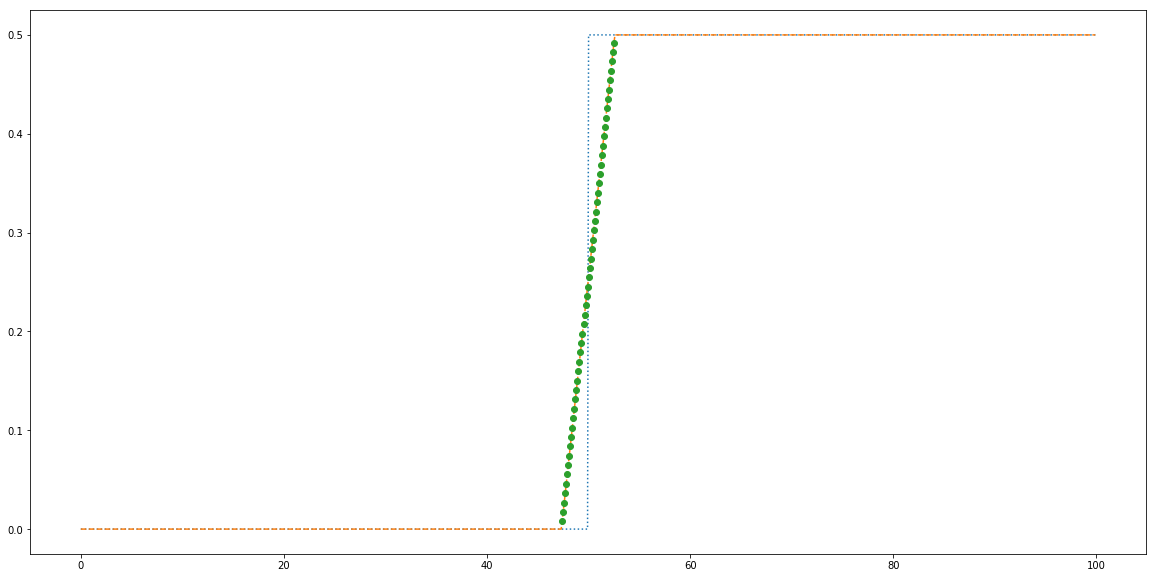

In [310]:
importlib.reload(synthetic_data);
from stay_classification.synthetic_data import get_1bump, get_bumps, get_noisy_bumps, get_noise

connect = 1100
dc = {
        "bump_amp":  0.5, "bump_slope": 0.095, "bump_slope_out": 0.95, "bump_start": 50 , "bump_end": connect
     }


bump_amp   = dc['bump_amp']
bump_slope = dc['bump_slope']
bump_slope_out = dc['bump_slope_out']
bump_start = dc['bump_start']
bump_end   = dc['bump_end']

yyy = 0*xxx

bump_start_ind = np.where((xxx>=bump_start))[0][0]

bump_end_ind = np.where((xxx<bump_end))[0][0]


bump_mask = np.where((xxx>=bump_start) & (xxx<bump_end))
yyy[bump_mask] = bump_amp

yyy0 = yyy.copy()

# Get the pre- & post-step indices
bump_start_ind = bump_mask[0][0]
bump_end_ind = bump_mask[0][-1]

# Get the midpoint values within the step
ymid_start = np.mean(yyy[bump_start_ind-1:bump_start_ind+1])
xmid_start = np.mean(xxx[bump_start_ind-1:bump_start_ind+1])

# Get the pre- & post-step amplitudes
y0_start_end = yyy[bump_start_ind:bump_start_ind+1][-1]
y0_start_start = yyy[bump_start_ind-1:bump_start_ind][0]

# Get the pre- & post-step amplitudes
y0_end_end = yyy[bump_end_ind:bump_end_ind+2][-1]
y0_end_start = yyy[bump_end_ind-1:bump_end_ind][-1]

# Get the midpoint values within the step
ymid_end = np.mean(yyy[bump_end_ind:bump_end_ind+2])
xmid_end = np.mean(xxx[bump_end_ind-1:bump_end_ind+1])


# Get the x-locations for the start and end of the sloped region
x0_start_end = get_x0(bump_slope, xmid_start, ymid_start, y0_start_end)
x0_start_start = get_x0(bump_slope, xmid_start, ymid_start, y0_start_start)
bump_slope_mask_in = np.where((xxx>=x0_start_start) & (xxx<x0_start_end))
'''
# Compute the sloped region
yyy[bump_slope_mask_in] = bump_slope*(xxx[bump_slope_mask_in]-x0_start_start) + y0_start_start

# Get the x-locations for the start and end of the sloped region
return_slope = -bump_slope
x0_end_start = get_x0(return_slope, xmid_end, ymid_end, y0_end_start)
x0_end_end   = get_x0(return_slope, xmid_end, ymid_end, y0_end_end)
bump_slope_mask_out = np.where((xxx>=x0_end_start) & (xxx<x0_end_end))

# Compute the sloped region
yyy[bump_slope_mask_out] = return_slope*(xxx[bump_slope_mask_out]-x0_end_start) + y0_end_start
'''

plt.figure(figsize=(20,10))
plt.plot(xxx, yyy0, ':', label=r'$y_0(x)$')

# plot
plt.plot(xxx, yyy, '--', label=f'slope = {bump_slope}')
plt.plot(xxx[bump_slope_mask_in], yyy[bump_slope_mask_in], 'o', label=f'slope = {bump_slope}')

#### data prep

In [315]:
# Get the slope region (from above)
begin_slope = bump_slope_mask_in[0][0]-1
end_slope = bump_slope_mask_in[0][-1]+1
print(begin_slope, end_slope)

473 526


In [332]:
# Get x-mean, for the slope func's x-offset
xmean = np.mean(xxx[begin_slope:end_slope+1])
ymean = np.mean(yyy[begin_slope:end_slope+1])
print(xxx[begin_slope],xmean,xxx[end_slope+1])
print(yyy[begin_slope],ymean,yyy[end_slope+1])

47.300000000000004 49.95 52.7
0.0 0.2500000000000004 0.5


In [316]:
# Get a buffer around the slope region 
#    * will need so specify bounds to keep from overlapping with other bumps)
begin_slope_buff = int(np.mean([0,begin_slope]))
end_slope_buff = int(np.mean([begin_slope, xxx.size]))

In [329]:
xdata = xxx[begin_slope_buff:end_slope_buff+1]
ydata = yyy[begin_slope_buff:end_slope_buff+1]

#### curve-fitting

In [905]:
from scipy.optimize import curve_fit

In [906]:
def slope_func(xmean):
    def inner (x,a,b,c): 
        return a*np.tanh(b*(x-xmean)) + c
    return inner

In [334]:
popt, pcov = curve_fit(slope_func(xmean), xdata, ydata)
print(popt)
print(pcov)

[0.25125706 0.49869477 0.25006775]
[[ 1.17445003e-07 -5.42167530e-07  6.32937146e-09]
 [-5.42167530e-07  2.46562547e-05 -2.92186047e-08]
 [ 6.32937146e-09 -2.92186047e-08  9.71109411e-08]]


#### Plotting

[0.25125706 0.49869477 0.25006775]


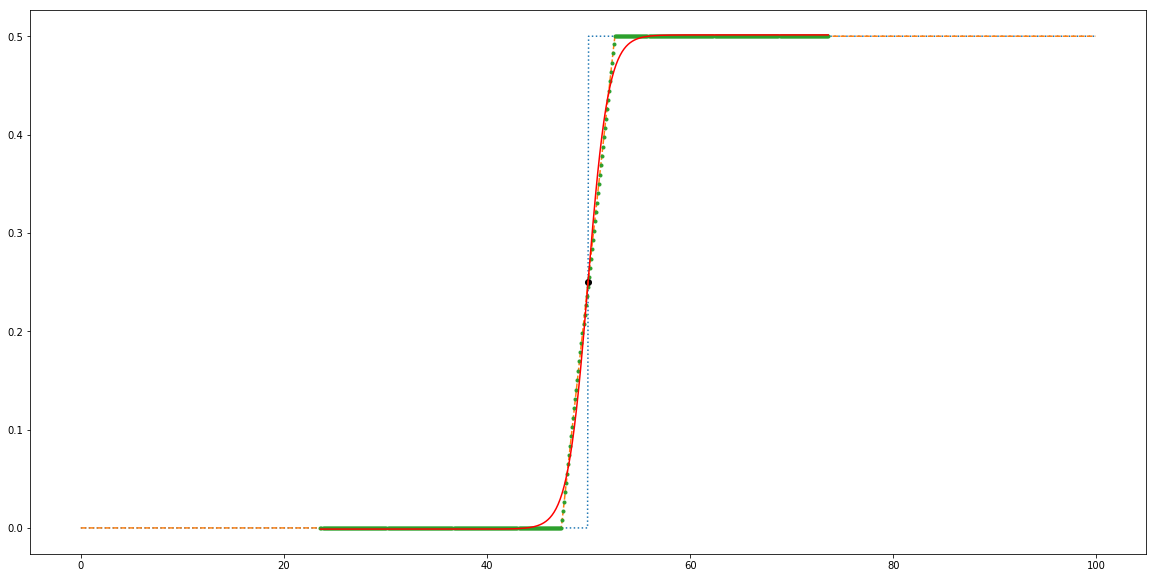

In [331]:
plt.figure(figsize=(20,10))
plt.plot(xxx, yyy0, ':', label=r'$y_0(x)$')

# plot
plt.plot(xmean, ymean, 'ko', label=f'mean')
plt.plot(xxx, yyy, '--', label=f'slope = {bump_slope}')
plt.plot(xdata, ydata, '.', label=f'slope = {bump_slope}')

plt.plot(xdata, slope_func(xmean)(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

In [907]:
xdata = xxx[1:101]
ydata = yyys[1:101]
xmean = xdata.mean()
popt, pcov = curve_fit(slope_func(xmean), xdata, ydata)
print(popt)
print(pcov)

plt.figure(figsize=(20,10))
plt.plot(xxx, yyy0, ':', label=r'$y_0(x)$')

# plot
plt.plot(xmean, ymean, 'ko', label=f'mean')
plt.plot(xxx, yyy, '--', label=f'slope = {bump_slope}')
plt.plot(xdata, ydata, '.', label=f'slope = {bump_slope}')

plt.plot(xdata, slope_func(xmean)(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.